In [1]:
## The Demo model

In [22]:
""" Demo of node classification """
import sys
sys.path.append('/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2')

import numpy as np
import random
import torch
import torch.nn.functional as F
from torch.nn import Linear, ModuleList, ReLU, Tanh, Sequential, ELU
from torch_geometric.nn import GCNConv, GATConv


from psd_gnn.dataset import Merge_PSD_Dataset, PSD_Dataset
# from psd_gnn.models.node_classifier import GNN
from psd_gnn.utils import process_args
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, precision_score, roc_auc_score,
                             recall_score)
from torch.nn import CrossEntropyLoss
from datetime import datetime
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from torch.distributions import Gumbel as G
torch.manual_seed(0)

In [23]:
class GNN(torch.nn.Module):
    def __init__(self,
                 n_node_features: int,
                 n_hidden: int,
                 n_output: int,
                 n_conv_blocks: int = 1,
                 dropout:float = 0.7) -> None:
        """ Init the GNN model (new version).

        Args:
            n_node_features (int): Number of features at node level.
            n_hidden (int): Number of hidden dimension.
            n_output (int): number of output dimension
            n_conv_blocks (int): Number of
        """
        # super class the class structure
        super().__init__()

        # add the ability to add one or more conv layers
        conv_blocks = []

        # ability to  add one or more conv blocks
        for _ in range(n_conv_blocks):
            conv_blocks += [
                GCNConv(n_node_features, n_hidden),
               ReLU(),
                GCNConv(n_hidden, n_hidden),
                ReLU(),
            ]
            # REVIEW: with attention layers
            # conv_blocks += [
            #     GATConv(n_node_features, 8, heads=8, dropout=0.5),
            #     ELU(),
            #     GATConv(8 * 8, n_hidden, heads=1, concat=False, dropout=0.5),
            # ]
        # group all the conv layers
        self.conv_layers = ModuleList(conv_blocks)
        self.dropout = dropout

        # add the linear layers for flattening the output from MPNN
        self.summary_statistics = Sequential(
            Linear(n_hidden, n_hidden),
            ReLU(),
            Linear(n_hidden, n_output),
        )

        self.dist = G(torch.tensor([1.0]), torch.tensor([0.5]))
        self.loss = torch.nn.BCEWithLogitsLoss()


    def forward(self,
                x: torch.Tensor,
                edge_index: torch.Tensor) -> torch.Tensor:
        """ Processing the GNN model.

        Args:
            x (torch.Tensor): Input features at node level.
            edge_index (torch.Tensor): Index pairs of vertices

        Returns:
            torch.Tensor: output tensor.
        """
        # process the layers
        for layer in self.conv_layers:
            if isinstance(layer, GCNConv) or isinstance(layer, GATConv):
                x = layer(x, edge_index)
            else:
                x = layer(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        out   = self.summary_statistics(x)
        return out# pass the output to the linear output layer
    
    def loss_func(self, y, out):
        loss_cross_entropy = self.loss(out, y.float())
        sample =self.dist.log_prob(self.dist.sample_n( out.size(0)).squeeze(1))
        out = torch.sigmoid(out)
        KLD = torch.sum(out * sample, dim=-1).mean()
        # loss_extreme = -1*torch.mean(out- sample -torch.mul(out, torch.log( out/(sample) ) ) )
        return KLD

In [24]:
from psd_gnn.dataset_v2 import PSD_Dataset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
DEVICE = torch.device("cpu")
dataset = Merge_PSD_Dataset(node_level=True, binary_labels=True).shuffle()
dataset[0].y[dataset[0].y> 0 ] =  1

data = dataset[0]
n_nodes = data.num_nodes
NUM_NODE_FEATURES = dataset.num_node_features
NUM_OUT_FEATURES = 1
print(NUM_NODE_FEATURES, NUM_OUT_FEATURES)


24 1


In [5]:
''' Build GNN model '''
model = GNN(NUM_NODE_FEATURES, 64, NUM_OUT_FEATURES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
scheduler = ReduceLROnPlateau(optimizer, 'min')

ts_start = datetime.now().strftime('%Y%m%d_%H%M%S')
pbar = tqdm(range(500), desc=f"all")
best = 0
for e in pbar:
    model.train()
    optimizer.zero_grad()
    y_hat = model(data.x, data.edge_index).squeeze()
    train_loss = model.loss_func(data.y[data.train_mask], y_hat[data.train_mask])
    train_loss.backward()
    optimizer.step()
    train_lab = torch.sigmoid(y_hat[data.train_mask]).detach().cpu().numpy()
    train_lab[train_lab<0.75] = 0
    train_lab[train_lab>=0.75] = 1
    train_acc = accuracy_score(data.y[data.train_mask].detach().cpu().numpy(), train_lab) 
    val_y_true = data.y[data.val_mask].detach().cpu().numpy()
    val_y_pred = torch.sigmoid(y_hat[data.val_mask]).detach().cpu().numpy()
    val_y_pred[val_y_pred<0.75] = 0 
    val_y_pred[val_y_pred>=0.75] = 1
    val_acc = accuracy_score(val_y_true, val_y_pred)
    
    
    pbar.set_postfix({"train_loss": train_loss.detach().numpy(),
                      "train_acc": train_acc,
                      "val_acc": val_acc})
    scheduler.step(train_loss)
    
    
#     if e%100==0:
#         actual_Data =  model.dist.log_prob(model.dist.sample_n( 10000 ))
#         args = np.argsort(actual_Data.squeeze(1).detach().numpy() )
#         actual_Data = actual_Data[args].squeeze(1).detach().numpy()
#         x, bins, p = plt.hist(torch.sigmoid(y_hat).detach().numpy(), color='orange', density=True)
#         # _,_,_ = plt.hist(actual_Data, bins, color='blue', alpha=0.1, density=True)
#         for item in p:
#             item.set_height(item.get_height()/sum(x))
        
#         # plt.xlim([0,1])
#         # plt.ylim([0,1])
#         plt.show()

all:  30%|▎| 148/500 [00:30<01:13,  4.80it/s, train_loss=-73312.63, train_acc=0.


KeyboardInterrupt: 

In [ ]:
## The final training metrics
ys = []
train_acc, y_pred = test(model, train_loader)
for data in train_loader:
    # ys.append(data.y.item())
    ys += data.y.detach().cpu().numpy().tolist()
y_true = ys
print(confusion_matrix(y_true, y_pred))

test_acc, y_pred = test(model, test_loader)

y_true = []
for data in test_loader:
    y_true += data.y.detach().cpu().numpy().tolist()

print(np.unique(y_pred, return_counts=True), \
     "real", np.unique(y_true, return_counts=True) )

conf_mat = confusion_matrix(y_true, y_pred)
prec_val = precision_score(y_true, y_pred)
f1_val = f1_score(y_true, y_pred)
recall_val = recall_score(y_true, y_pred)


print("graph level clf:",
      f"workflow all",
      f"binary True",
      f"test acc {test_acc:.4f}",
      f"f1 {f1_val:.4f}",
      f"recall {recall_val:.4f}",
      f"prec {prec_val:.4f}",
      )
print(conf_mat)

In [ ]:
## The Graph Model

In [25]:
""" Demo of node classification """
import numpy as np
import random
import torch
import torch.nn.functional as F
from torch.nn import Linear, ModuleList, ReLU, Tanh, Sequential, ELU

from psd_gnn.utils import process_args
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, precision_score, roc_auc_score,
                             recall_score)
from torch.nn import CrossEntropyLoss
from datetime import datetime
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from torch.distributions import Gumbel as G
torch.manual_seed(0)

In [26]:
## Generate data from a Gumbel distribution
data_sample_1 = torch.normal(0, 1, [20000, 24]).squeeze(0)
data_sample_2 = torch.normal(0, 1.1, [20000, 24]).squeeze(0)
data = torch.cat([data_sample_1, data_sample_2], axis=0)
y = torch.cat([torch.zeros(data_sample_1.size(0)), torch.zeros(data_sample_2.size(0))], axis=0)
print(data.shape, y.shape)
print(data)

torch.Size([40000, 24]) torch.Size([40000])
tensor([[-1.1258, -1.1524, -0.2506,  ..., -1.5551, -0.3414,  1.8530],
        [ 0.7502, -0.5855, -0.1734,  ...,  2.3022, -1.4689, -1.5867],
        [-0.6731,  0.8728,  1.0554,  ...,  2.5672, -0.4731,  0.3356],
        ...,
        [-0.2087, -0.3192,  0.6482,  ...,  1.8107, -0.1552, -0.8880],
        [ 2.1366,  1.3186, -0.9975,  ...,  1.0791, -0.8915,  1.0632],
        [ 0.9393,  0.7477, -1.5297,  ...,  1.1215,  0.5136, -0.9894]])


In [27]:
## Generate data from a Gumbel distribution
data_sample_1 = torch.normal(0,1, [2000, 24]).squeeze(0)
data_sample_2 = torch.normal(0,2, [2000, 24]).squeeze(0)
test = torch.cat([data_sample_1, data_sample_2], axis=0)
yt = torch.zeros(test.size(0))
print(test.size(), yt.size())

torch.Size([4000, 24]) torch.Size([4000])


In [28]:
from torch.utils.data import Dataset, DataLoader
class Continual_Dataset(Dataset):
    def __init__(self, data_x, data_y):
        self.x  = data_x
        self.y  = data_y

    # A function to define the length of the problem
    def __len__(self):
        return self.x.shape[0]

    # A function to get samples
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        x_=  self.x[idx,:]
        y_=  self.y[idx]
        
        sample = {'x': x_, 'y': y_}
        return sample
    
dataset = Continual_Dataset(data, y)
dataloader = DataLoader(dataset, batch_size= 64,\
                        shuffle=True, num_workers=0)
print(dataloader)
def numpy_sigmoid(x):
    return 1/(1 + np.exp(-x))

In [29]:
class Net(torch.nn.Module):

    def __init__(self, n_hidden=256, n_output=1):
        super(Net, self).__init__()
        # add the linear layers for flattening the output from MPNN
        self.summary_statistics = Sequential(
            Linear(24, n_hidden),
            ReLU(),
            Linear(n_hidden, n_hidden),
            ReLU(),
            Linear(n_hidden, n_output),
        )

        self.dist = G(torch.tensor([1.0]), torch.tensor([0.2]))
        # self.loss = torch.nn.BCEWithLogitsLoss()
        
    
    def forward(self, x):
        # print(x.shape)
        # Max pooling over a (2, 2) window
        return self.summary_statistics(x)
    
    def loss_func(self, y, out):
        # loss_cross_entropy = self.loss(out, y.float())
        sample =self.dist.log_prob(self.dist.sample_n( out.size(0)).squeeze(1)).exp()
        out = torch.sigmoid(out)
        loss_extreme = -1*torch.mean(out- sample -torch.mul(out, torch.log( out/(sample+1e-10) ) ) )
        return loss_extreme

all:   0%|                          | 0/50 [00:00<?, ?it/s, train_loss=0.266884]

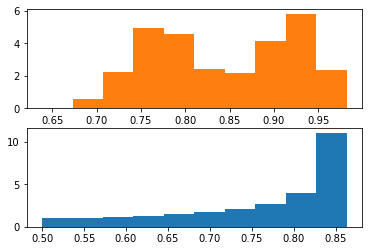

all:  20%|███▏            | 10/50 [00:06<00:22,  1.75it/s, train_loss=0.1747602]

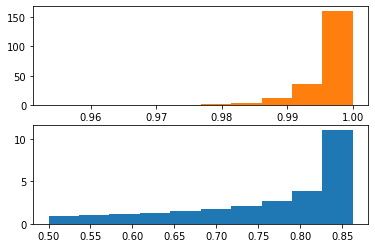

all:  40%|██████         | 20/50 [00:12<00:16,  1.78it/s, train_loss=0.24296632]

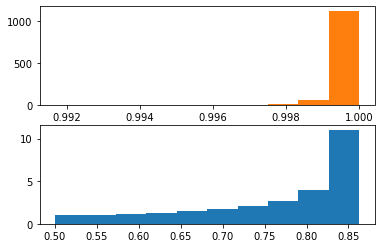

all:  60%|█████████      | 30/50 [00:18<00:11,  1.72it/s, train_loss=0.15838504]

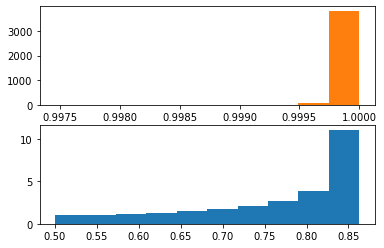

all:  80%|████████████   | 40/50 [00:24<00:06,  1.66it/s, train_loss=0.15865405]

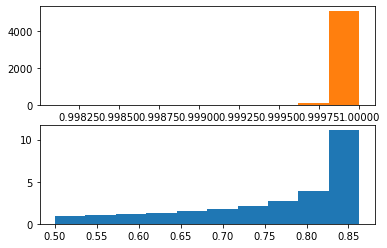

all: 100%|███████████████| 50/50 [00:29<00:00,  1.70it/s, train_loss=0.13790627]


In [31]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
''' Build GNN model '''
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-05)
scheduler = ReduceLROnPlateau(optimizer, 'min')
ts_start = datetime.now().strftime('%Y%m%d_%H%M%S')
best = 0
model.train()

with tqdm(range(50), desc=f"all") as pbar:
    for e in pbar:
        for (idx,batch) in enumerate(dataloader):
            x_b = batch['x']
            y_b = batch['y']
            # print(x_b, y_b)
            optimizer.zero_grad()
            y_hat = model(x_b).squeeze()
            train_loss = model.loss_func(y_b, y_hat)
            train_loss.backward()
            optimizer.step()
            
            
            
        pbar.set_postfix({"train_loss": train_loss.detach().numpy()})
        scheduler.step(train_loss)

        if e%10==0:

            y_hat = model(test).squeeze()
            actual_Data =  model.dist.log_prob(model.dist.sample_n( 100000 )).exp()
            args = np.argsort(actual_Data.squeeze(1).detach().numpy() )
            actual_Data = actual_Data[args].squeeze(1).detach().numpy()
            fig, axs = plt.subplots(2)
            _, _, _ = axs[0].hist(torch.sigmoid(y_hat).detach().numpy(), color='tab:orange', density=True)
            _,_,_ = axs[1].hist(numpy_sigmoid(actual_Data), color='tab:blue', density=True)
            plt.show()
            plt.close

torch.Size([4000, 24]) torch.Size([4000])


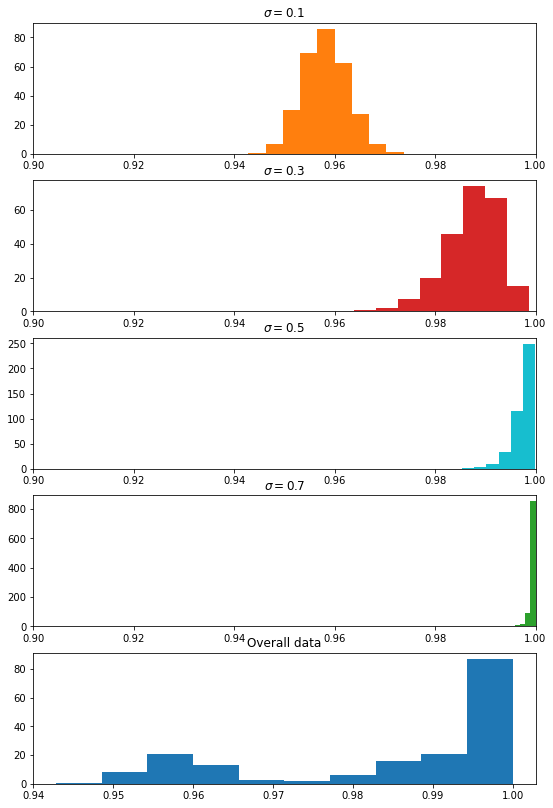

In [38]:
## Generate data from a Gumbel distribution
data_sample_1 = torch.normal(0,0.1, [20000, 24]).squeeze(0)
data_sample_2 = torch.normal(0,0.3,\
                             [20000, 24]).squeeze(0)
data_sample_3 = torch.normal(0,0.5,\
                             [20000, 24]).squeeze(0)
data_sample_4 = torch.normal(0,0.7,\
                             [20000, 24]).squeeze(0)

yt = torch.zeros(test.size(0))
print(test.size(), yt.size())

data= torch.cat([data_sample_1, data_sample_2, data_sample_3, data_sample_4])
actual_Data =  model.dist.log_prob(model.dist.sample_n( 10000 )).exp()
args = np.argsort(actual_Data.squeeze(1).detach().numpy() )
actual_Data = actual_Data[args].squeeze(1).detach().numpy()

fig, axs = plt.subplots(5, figsize=(9, 14))
y_hat = model(data_sample_1).squeeze()
_, bins, _ = axs[0].hist(torch.sigmoid(y_hat).detach().numpy(), color='tab:orange',  density=True)
axs[0].set_title('$\\sigma = 0.1$')
axs[0].set_xlim([0.9,1])
y_hat = model(data_sample_2).squeeze()
_, _, _ = axs[1].hist(torch.sigmoid(y_hat).detach().numpy(),  color='tab:red', density=True)
axs[1].set_title('$\\sigma = 0.3$')
axs[1].set_xlim([0.9,1])
y_hat = model(data_sample_3).squeeze()
_, _, _ = axs[2].hist(torch.sigmoid(y_hat).detach().numpy(),  color='tab:cyan', density=True)
axs[2].set_title('$\\sigma = 0.5$')
axs[2].set_xlim([0.9,1])
y_hat = model(data_sample_4).squeeze()
_, _, _ = axs[3].hist(torch.sigmoid(y_hat).detach().numpy(), color='tab:green',density=True)
axs[3].set_title('$\\sigma = 0.7$')
axs[3].set_xlim([0.9,1])

y_hat = model(data).squeeze()
_,_,_ = axs[4].hist(torch.sigmoid(y_hat).detach().numpy(), color='tab:blue', density=True)
axs[4].set_title('Overall data')

#plt.xlim([0.8,1])
#plt.ylim([0,1])
plt.show()

In [13]:
## Now the network

In [39]:
""" Demo of node classification """
import sys
sys.path.append('/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2')

import numpy as np
import random
import torch
import torch.nn.functional as F
from torch.nn import Linear, ModuleList, ReLU, Tanh, Sequential, ELU
from torch_geometric.nn import GCNConv, GATConv


from psd_gnn.dataset import Merge_PSD_Dataset, PSD_Dataset
# from psd_gnn.models.node_classifier import GNN
from psd_gnn.utils import process_args
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, precision_score, roc_auc_score,
                             recall_score)
from torch.nn import CrossEntropyLoss
from datetime import datetime
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from torch.distributions import Gumbel as G
torch.manual_seed(0)

In [40]:
class GNN(torch.nn.Module):
    def __init__(self,
                 n_node_features: int,
                 n_hidden: int,
                 n_output: int,
                 n_conv_blocks: int = 1,
                 dropout:float = 0.7) -> None:
        """ Init the GNN model (new version).

        Args:
            n_node_features (int): Number of features at node level.
            n_hidden (int): Number of hidden dimension.
            n_output (int): number of output dimension
            n_conv_blocks (int): Number of
        """
        # super class the class structure
        super().__init__()

        # add the ability to add one or more conv layers
        conv_blocks = []

        # ability to  add one or more conv blocks
        for _ in range(n_conv_blocks):
            conv_blocks += [
                GCNConv(n_node_features, n_hidden),
               ReLU(),
                GCNConv(n_hidden, n_hidden),
                ReLU(),
            ]
            # REVIEW: with attention layers
            # conv_blocks += [
            #     GATConv(n_node_features, 8, heads=8, dropout=0.5),
            #     ELU(),
            #     GATConv(8 * 8, n_hidden, heads=1, concat=False, dropout=0.5),
            # ]
        # group all the conv layers
        self.conv_layers = ModuleList(conv_blocks)
        self.dropout = dropout

        # add the linear layers for flattening the output from MPNN
        self.summary_statistics = Sequential(
            Linear(n_hidden, n_hidden),
            ReLU(),
            Linear(n_hidden, n_output),
        )

        self.dist = G(torch.tensor([1.0]), torch.tensor([0.2]))
        self.loss = torch.nn.BCEWithLogitsLoss()


    def forward(self,
                x: torch.Tensor,
                edge_index: torch.Tensor) -> torch.Tensor:
        """ Processing the GNN model.

        Args:
            x (torch.Tensor): Input features at node level.
            edge_index (torch.Tensor): Index pairs of vertices

        Returns:
            torch.Tensor: output tensor.
        """
        # process the layers
        for layer in self.conv_layers:
            if isinstance(layer, GCNConv) or isinstance(layer, GATConv):
                x = layer(x, edge_index)
            else:
                x = layer(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        out   = self.summary_statistics(x)
        return out# pass the output to the linear output layer
    
    def loss_func(self, y, out):
        # loss_cross_entropy = self.loss(out, y.float())
        sample =self.dist.log_prob(self.dist.sample_n( out.size(0)).squeeze(1)).exp()
        out = torch.sigmoid(out)
        loss_extreme = -1*torch.mean(out- sample -torch.mul(out, torch.log( out/(sample) ) ) )
        return loss_extreme

In [53]:
from psd_gnn.dataset_v2 import PSD_Dataset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
DEVICE = torch.device("cpu")
dataset = Merge_PSD_Dataset(node_level=True, binary_labels=True).shuffle()
dataset[0].y[dataset[0].y> 0 ] =  1
data = dataset[0]

n_nodes = data.num_nodes
NUM_NODE_FEATURES = dataset.num_node_features
NUM_OUT_FEATURES = 1
print(NUM_NODE_FEATURES, NUM_OUT_FEATURES)

24 1


all:   0%| | 0/1000 [00:00<?, ?it/s, train_loss=0.39415258, train_acc=0.187, val

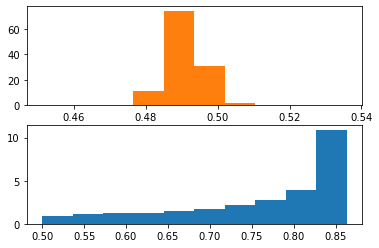

all:  10%| | 100/1000 [00:21<03:06,  4.83it/s, train_loss=0.3497214, train_acc=0

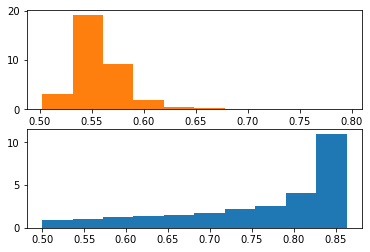

all:  20%|▏| 200/1000 [00:41<02:44,  4.86it/s, train_loss=0.25493976, train_acc=

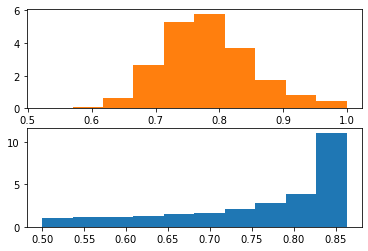

all:  30%|▎| 300/1000 [01:02<02:24,  4.86it/s, train_loss=0.22475338, train_acc=

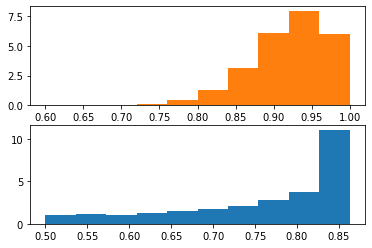

all:  40%|▍| 400/1000 [01:23<02:04,  4.83it/s, train_loss=0.22178236, train_acc=

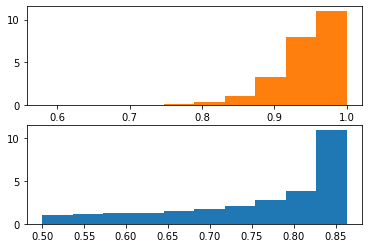

all:  50%|▌| 500/1000 [01:44<01:44,  4.78it/s, train_loss=0.22243786, train_acc=

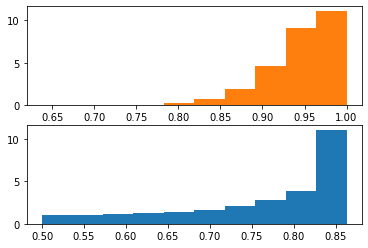

all:  60%|▌| 600/1000 [02:05<01:22,  4.82it/s, train_loss=0.22132517, train_acc=

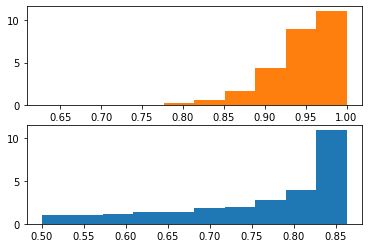

all:  70%|▋| 700/1000 [02:26<01:02,  4.83it/s, train_loss=0.22367205, train_acc=

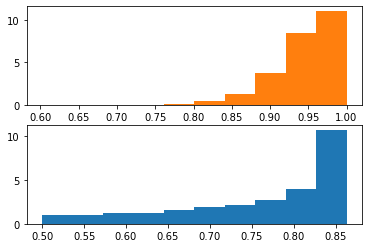

all:  80%|▊| 800/1000 [02:46<00:41,  4.81it/s, train_loss=0.22069575, train_acc=

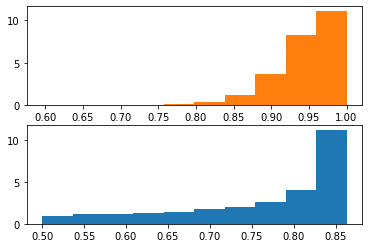

all:  90%|▉| 900/1000 [03:07<00:20,  4.79it/s, train_loss=0.22193013, train_acc=

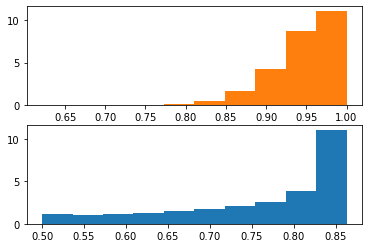

all: 100%|█| 1000/1000 [03:28<00:00,  4.80it/s, train_loss=0.22193529, train_acc


In [47]:
''' Build GNN model '''
model = GNN(NUM_NODE_FEATURES, 64, NUM_OUT_FEATURES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-04)
scheduler = ReduceLROnPlateau(optimizer, 'min')

ts_start = datetime.now().strftime('%Y%m%d_%H%M%S')
pbar = tqdm(range(1000), desc=f"all")
best = 0
for e in pbar:
    model.train()
    optimizer.zero_grad()
    y_hat = model(data.x, data.edge_index).squeeze()
    train_loss = model.loss_func(data.y[data.train_mask], y_hat[data.train_mask])
    train_loss.backward()
    optimizer.step()
    train_lab = torch.sigmoid(y_hat[data.train_mask]).detach().cpu().numpy()
    train_lab[train_lab<0.80] = 0
    train_lab[train_lab>=0.80] = 1
    train_acc = accuracy_score(data.y[data.train_mask].detach().cpu().numpy(), train_lab) 
    val_y_true = data.y[data.val_mask].detach().cpu().numpy()
    val_y_pred = torch.sigmoid(y_hat[data.val_mask]).detach().cpu().numpy()
    val_y_pred[val_y_pred<0.80] = 0 
    val_y_pred[val_y_pred>=0.80] = 1
    val_acc = accuracy_score(val_y_true, val_y_pred)
    
    
    pbar.set_postfix({"train_loss": train_loss.detach().numpy(),
                      "train_acc": train_acc,
                      "val_acc": val_acc})
    scheduler.step(train_loss)
    
    
    if e%100==0:
        actual_Data =  model.dist.log_prob(model.dist.sample_n( 10000 )).exp()
        args = np.argsort(actual_Data.squeeze(1).detach().numpy() )
        actual_Data = actual_Data[args].squeeze(1).detach().numpy()
        fig, axs = plt.subplots(2)
        _, _, _ = axs[0].hist(torch.sigmoid(y_hat).detach().numpy(), color='tab:orange', density=True)
        _,_,_ = axs[1].hist(numpy_sigmoid(actual_Data), color='tab:blue', density=True)
        plt.show()
        plt.close

In [51]:
print(data.x.size(), data.edge_index.size())

torch.Size([138974, 24]) torch.Size([2, 265346])


torch.Size([4000, 24]) torch.Size([4000])


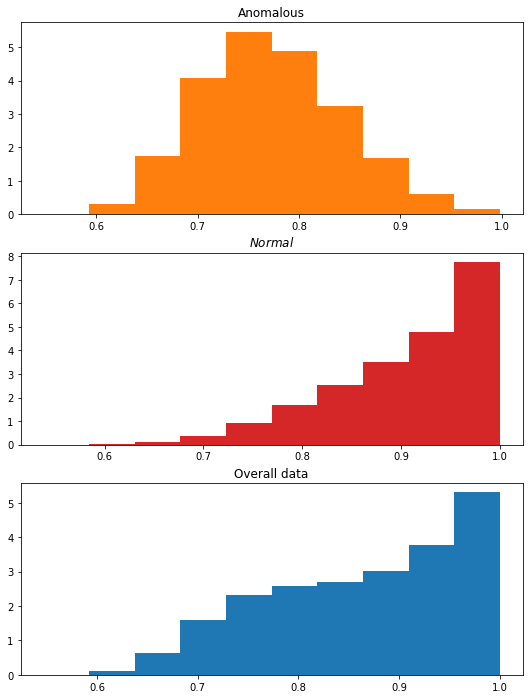

In [62]:
## Generate data from a Gumbel distribution
data_sample_1 = torch.normal(0,0.1, [138974, 24]).squeeze(0)
data_sample_2 = torch.normal(0,0.3,\
                             [138974, 24]).squeeze(0)
data_sample_3 = torch.normal(0,0.5,\
                             [138974, 24]).squeeze(0)
data_sample_4 = torch.normal(0,0.7,\
                             [138974, 24]).squeeze(0)

yt = torch.zeros(test.size(0))
print(test.size(), yt.size())

datum= torch.cat([data_sample_1, data_sample_2, data_sample_3])


fig, axs = plt.subplots(3, figsize=(9, 12))
y_hat = model(data_sample_1, data.edge_index).squeeze()
_, bins, _ = axs[0].hist(torch.sigmoid(y_hat).detach().numpy(), color='tab:orange',  density=True)
axs[0].set_title('Anomalous')
# axs[0].set_xlim([0.9,1])
y_hat = model(torch.cat([data_sample_2, data_sample_3]), data.edge_index).squeeze()
_, _, _ = axs[1].hist(torch.sigmoid(y_hat).detach().numpy(),  color='tab:red', density=True)
axs[1].set_title('$Normal$')
# axs[1].set_xlim([0.9,1])
# y_hat = model(data_sample_3, data.edge_index).squeeze()
# _, _, _ = axs[2].hist(torch.sigmoid(y_hat).detach().numpy(),  color='tab:cyan', density=True)
# axs[2].set_title('$\\sigma = 0.5$')
# axs[2].set_xlim([0.9,1])
# y_hat = model(data_sample_4, data.edge_index).squeeze()
# _, _, _ = axs[3].hist(torch.sigmoid(y_hat).detach().numpy(), color='tab:green',density=True)
# axs[3].set_title('$\\sigma = 0.7$')
# # axs[3].set_xlim([0.9,1])

y_hat = model(datum, data.edge_index).squeeze()
_,_,_ = axs[2].hist(torch.sigmoid(y_hat).detach().numpy(), color='tab:blue', density=True)
axs[2].set_title('Overall data')

#plt.xlim([0.8,1])
#plt.ylim([0,1])
plt.show()